# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [28]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import boxcox

# File sorting

`*` matches 0 or more characters.

In [2]:
file_list = glob('/nvme1/fwi-forcings/ECMWF_FO_20*.nc')

A sample of file names.

In [10]:
file_list[:3]

['/nvme1/fwi-forcings/ECMWF_FO_20191225_1200_hr_t2.nc',
 '/nvme1/fwi-forcings/ECMWF_FO_20190921_1200_hr_t2.nc',
 '/nvme1/fwi-forcings/ECMWF_FO_20191202_1200_hr_rh.nc']

Sorting files by time to get deterministic order when loaded.

In [3]:
files = sorted(sorted(file_list),
               key=lambda x: int(x.split("_20")[1][2:].split("_1200_hr_")[0][:2])*100 + int(x.split("_20")[1][2:].split("_1200_hr_")[0][2:]))

*Data is expected to be for 12 months -> 366 (Data for fwi-forcings) ***** 4 (number of variables)*

In [14]:
len(files)

1464

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.ng the files in a separate location (once) to prevent unintended modification.

In [21]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-forcings')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file. `h5netcdf` engine gives faster I/O compared to the default `netcdf4`.

In [7]:
xr.open_dataset(files[0], engine='h5netcdf')

<xarray.Dataset>
Dimensions:  (lat: 2560, lon: 5120, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-04-10
  * lon      (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -89.87648 -89.94619
Data variables:
    rh       (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jun 03 14:41:12 2020: cdo --silent -select,name=rh...
    Reference date:    20190401
    ECMWF fire model:  3.0
    Lincense:          Copernicus
    version:           3.0
    NCO:               4.6.7
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

Each file contains the observation along with 9 day forecast.

Selecting only the actual value for the task at hand. `isel` method allows selecting data by index slice.

In [5]:
def preprocess(d):
    return d.isel(time=slice(0,1))

Combining multiple files into single dataarray.

In [ ]:
proc = xr.open_mfdataset(files, preprocess=preprocess, engine='h5netcdf')

Taking a look.

In [17]:
proc

<xarray.Dataset>
Dimensions:  (lat: 2560, lon: 5120, time: 366)
Coordinates:
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -89.87648 -89.94619
  * lon      (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2019-12-31
Data variables:
    rh       (time, lat, lon) float32 dask.array<chunksize=(1, 2560, 5120), meta=np.ndarray>
    t2       (time, lat, lon) float32 dask.array<chunksize=(1, 2560, 5120), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(1, 2560, 5120), meta=np.ndarray>
    wspeed   (time, lat, lon) float32 dask.array<chunksize=(1, 2560, 5120), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Sat Jun 06 08:27:56 2020: cdo --silent -select,name=rh...
    Reference date:    20200101
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.7.8 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>
*Should match with fwi-forcings to not require interpolation*

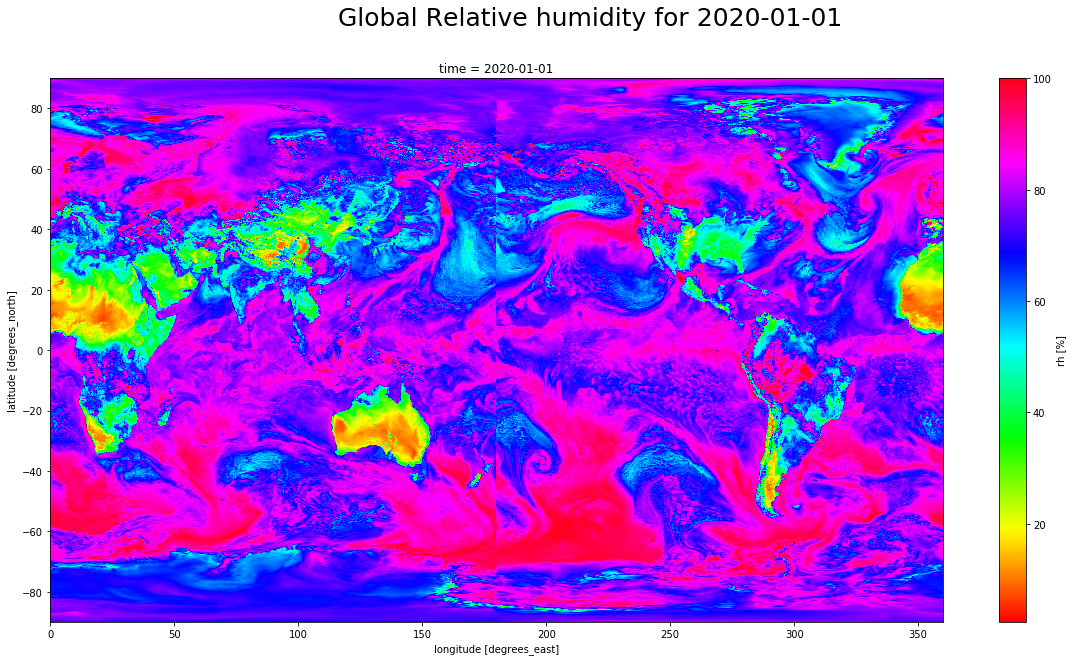

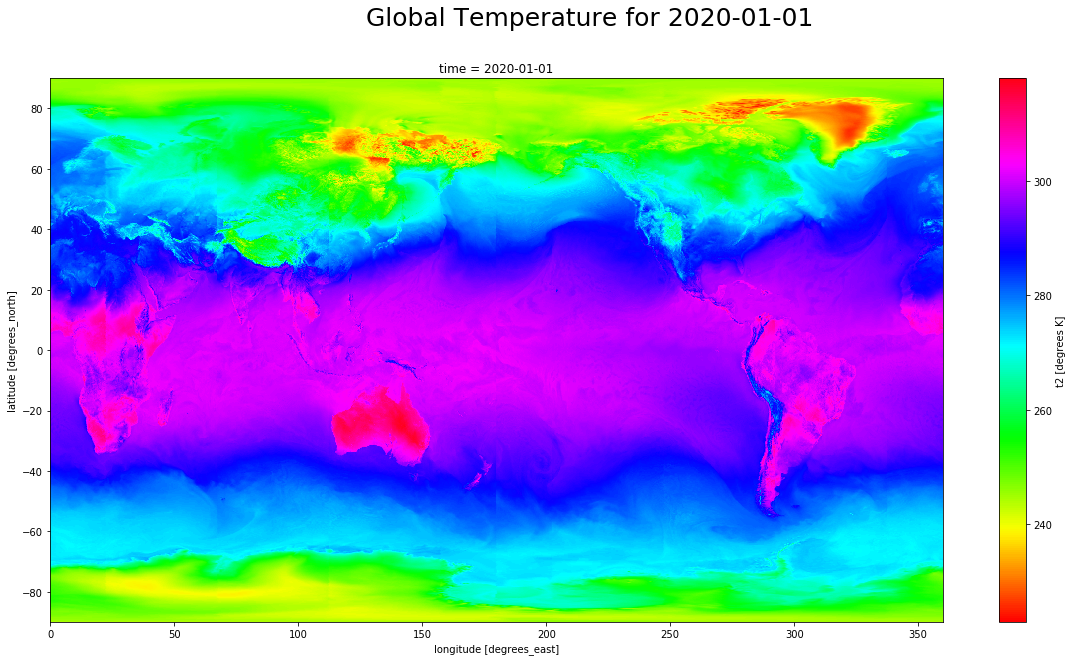

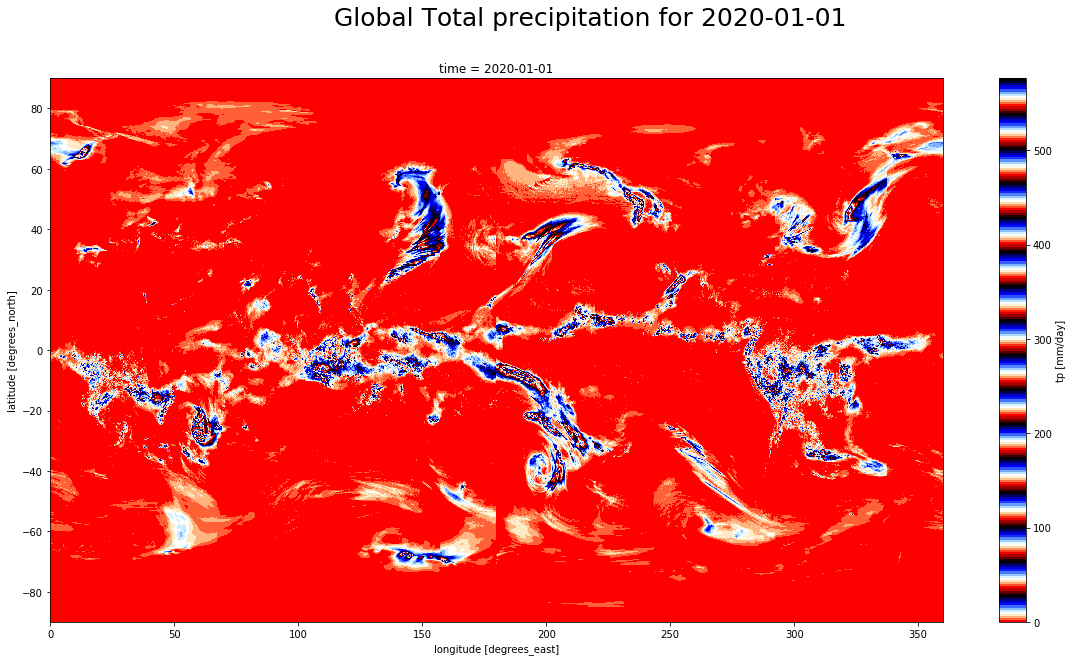

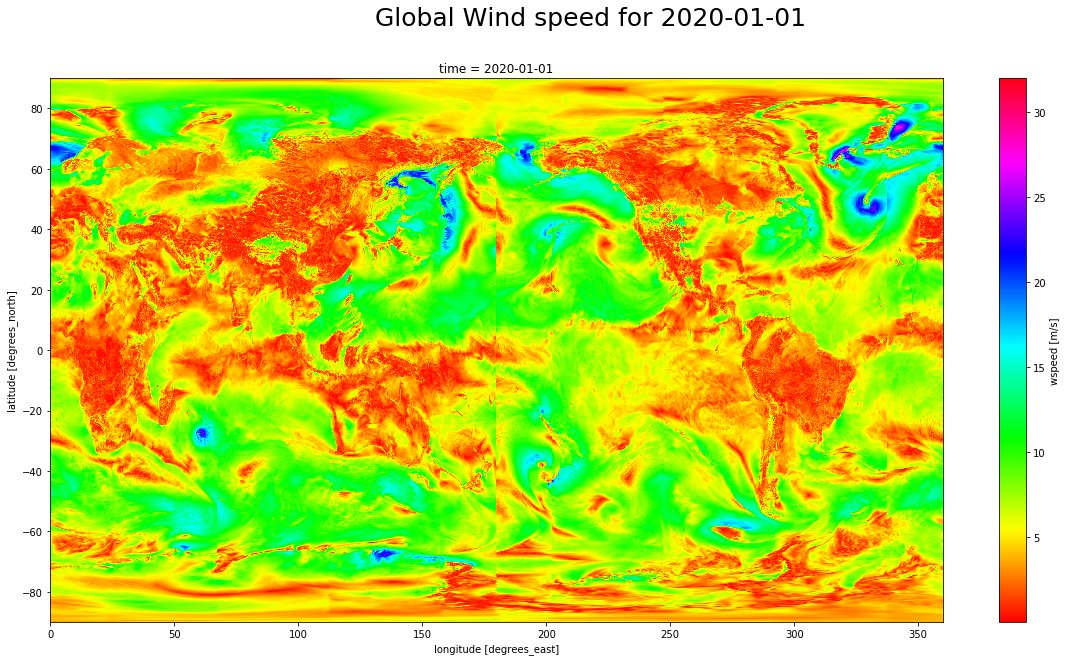

In [12]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'Global {var_list[i]} for 2020-01-01', fontsize=25)
    proc[list(proc.data_vars)[i]][0].plot(cmap='flag' if i==2 else 'hsv')
    plt.show()

*Notice the discontinuity in the middle*<br>
It is arising because of recording the data at local noon. Shifting the frame:

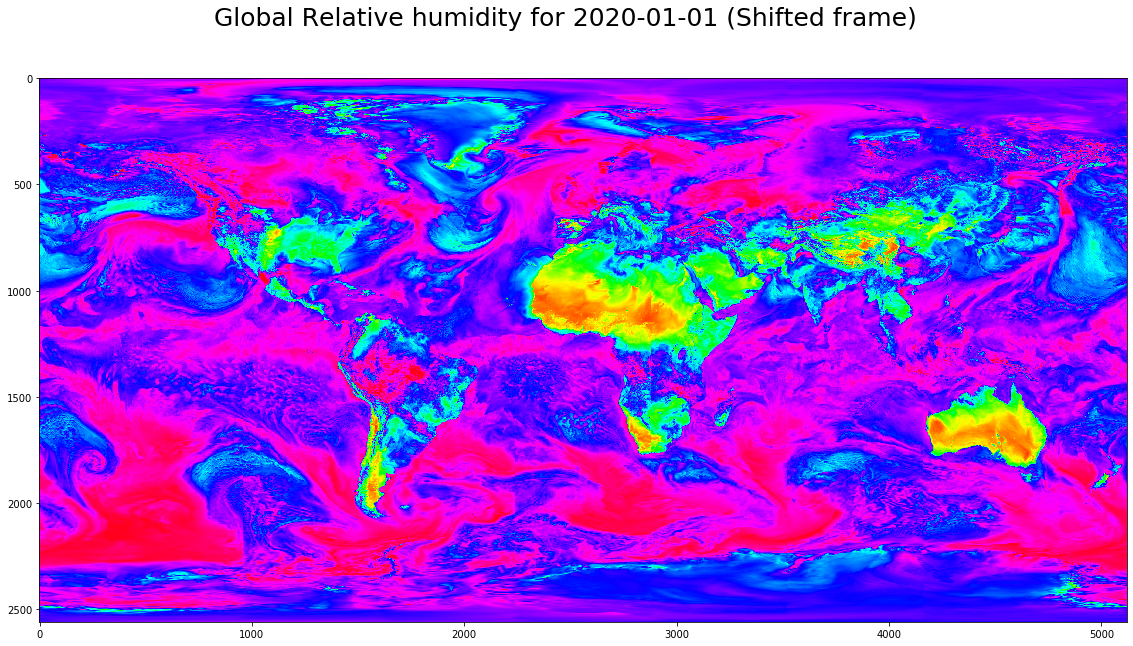

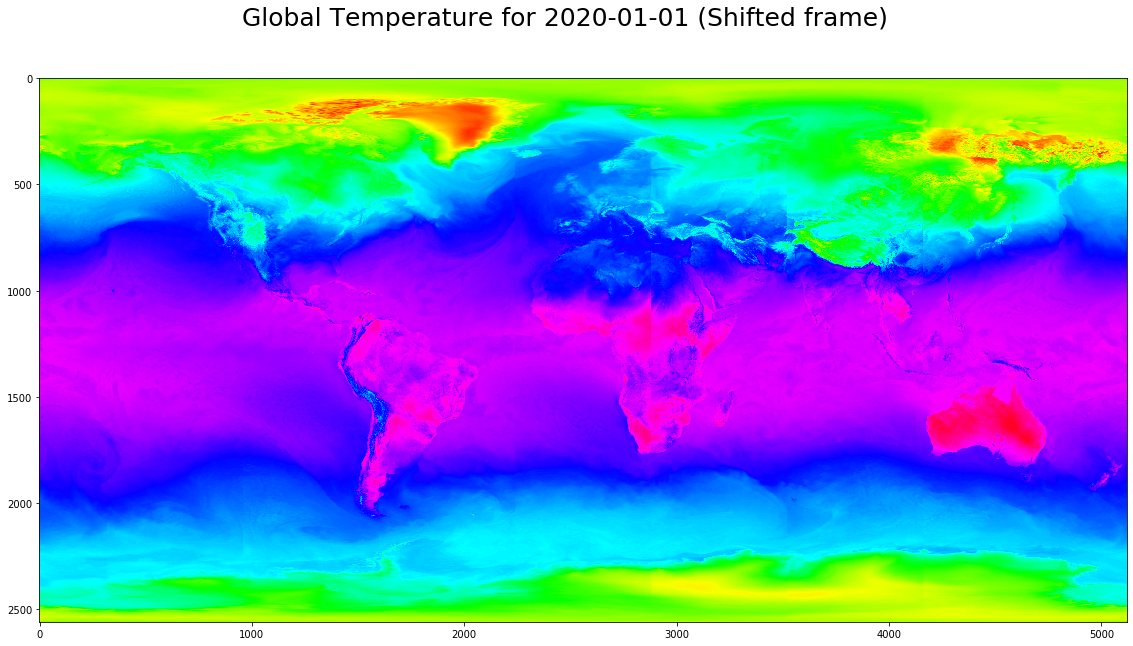

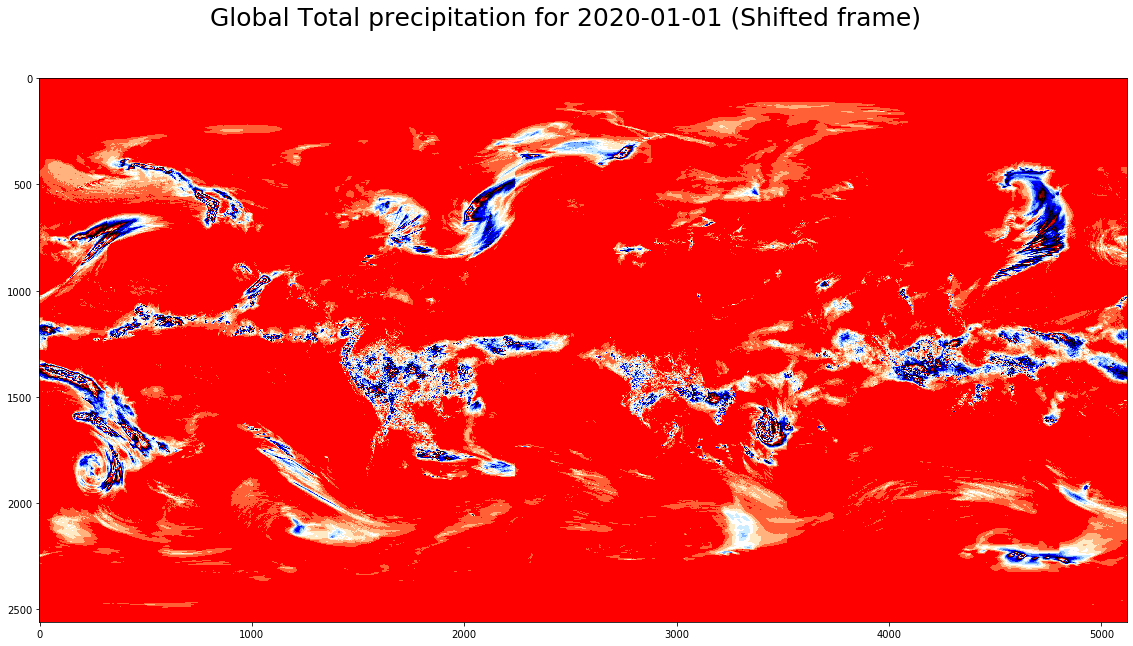

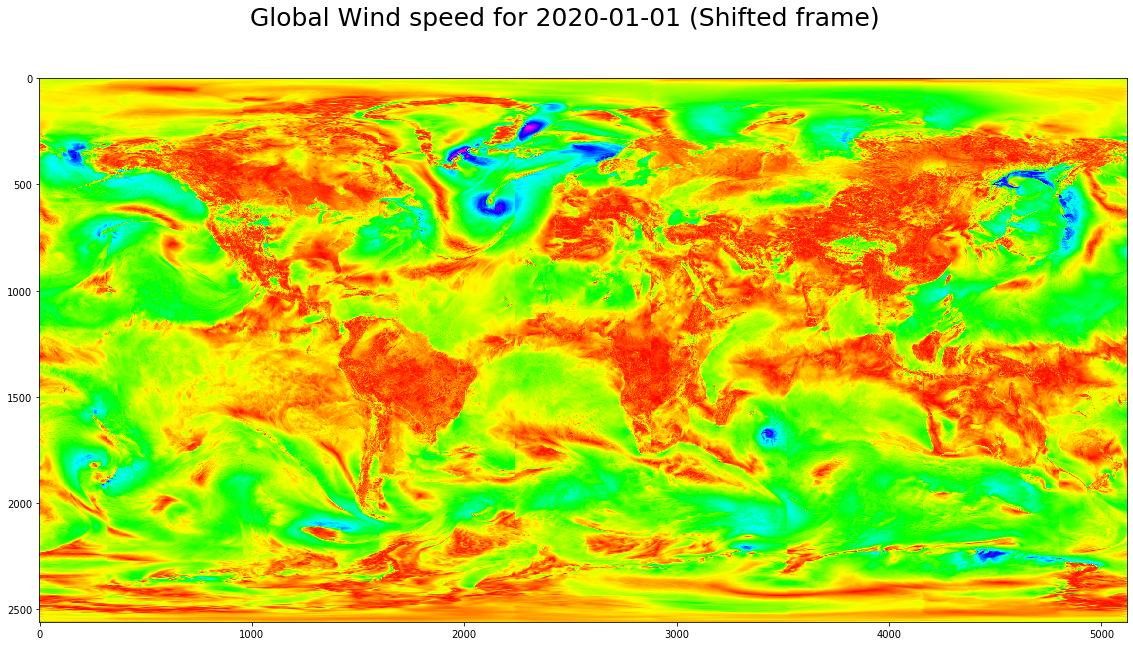

In [11]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'Global {var_list[i]} for 2020-01-01 (Shifted frame)', fontsize=25)
    plt.imshow(np.concatenate(
        (proc[list(proc.data_vars)[i]][0].values[:,2560:], proc[list(proc.data_vars)[i]][0].values[:,:2560]), axis=1
    ), cmap='flag' if i==2 else 'hsv')
    plt.show()

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [42]:
for i in proc.data_vars:
    print(np.isnan(proc[i][0].values).any())

False
False
False
False


Printing general stats.

In [29]:
def stats(x):
    tmp = x.mean()
    print('mean', tmp)
    print('mad', abs(x-tmp).mean())
    print('var', x.var())
    print('min', x.min())
    print('max', x.max())

In [21]:
stats(proc.rh.values)

mean 72.47605
mad 13.0844555
var 314.80286
min 0.0013500393
max 100.064285


In [22]:
stats(proc.t2.values)

mean 279.96622
mad 16.938044
var 452.84903
min 193.66562
max 324.16202


In [23]:
stats(proc.tp.values)

mean 2.4548044
mad 3.0407052
var 40.771793
min 0.0
max 1097.1971


In [24]:
stats(proc.wspeed.values)

mean 6.4765906
mad 2.936887
var 13.666987
min 5.722046e-05
max 47.25583


## Value distribution

#### Original data:

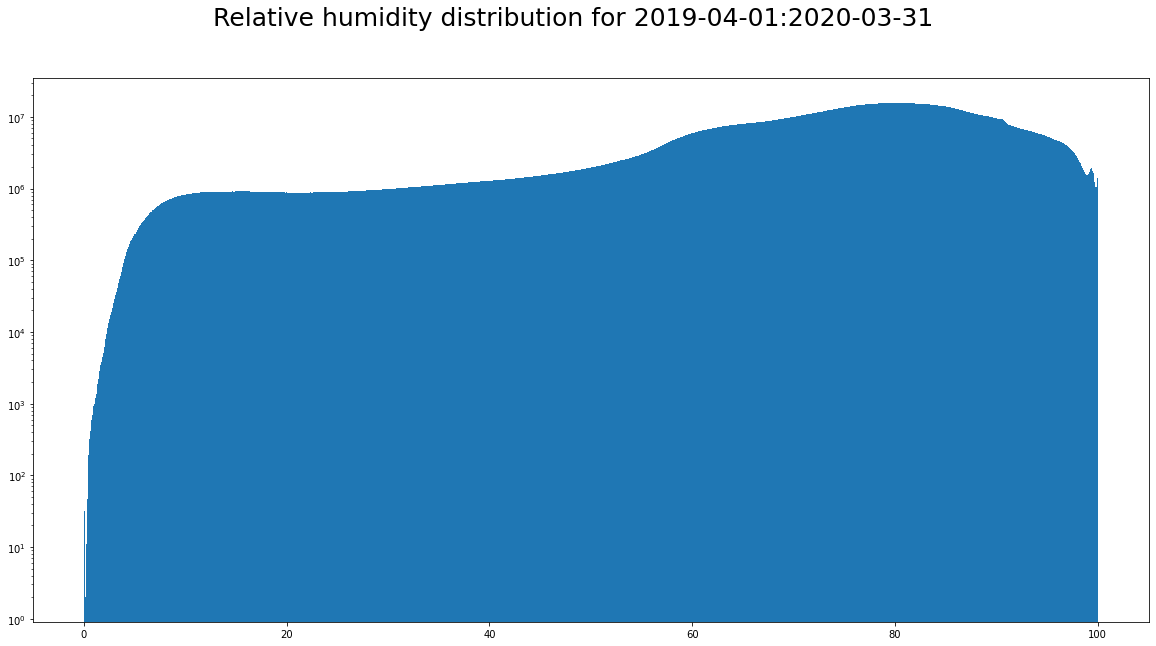

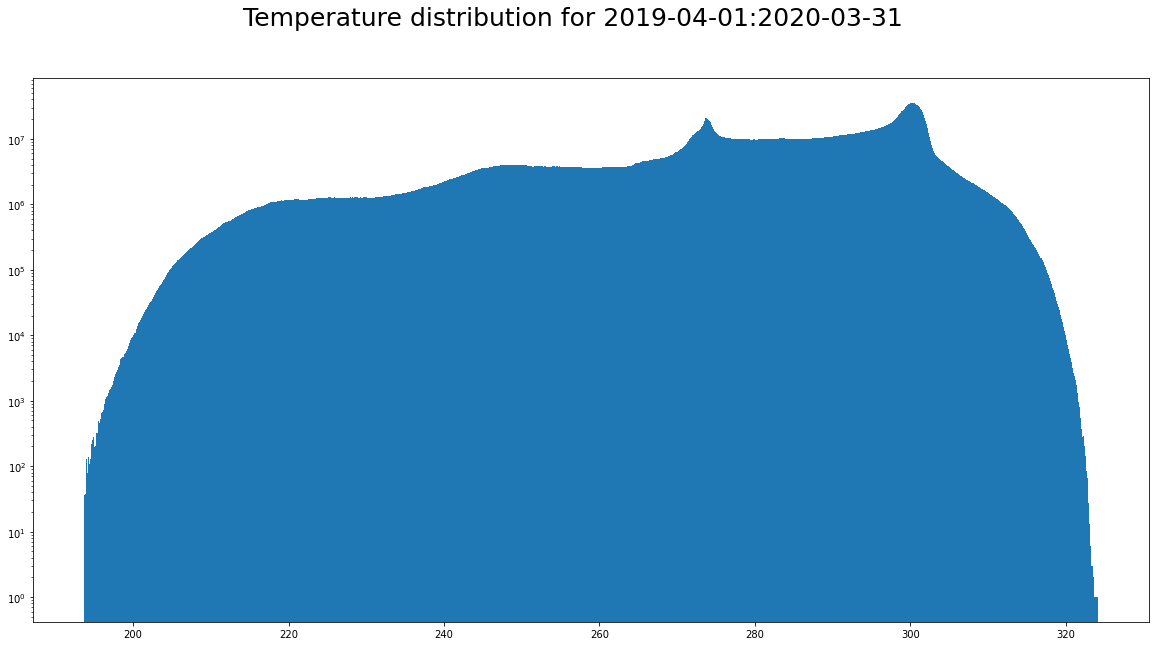

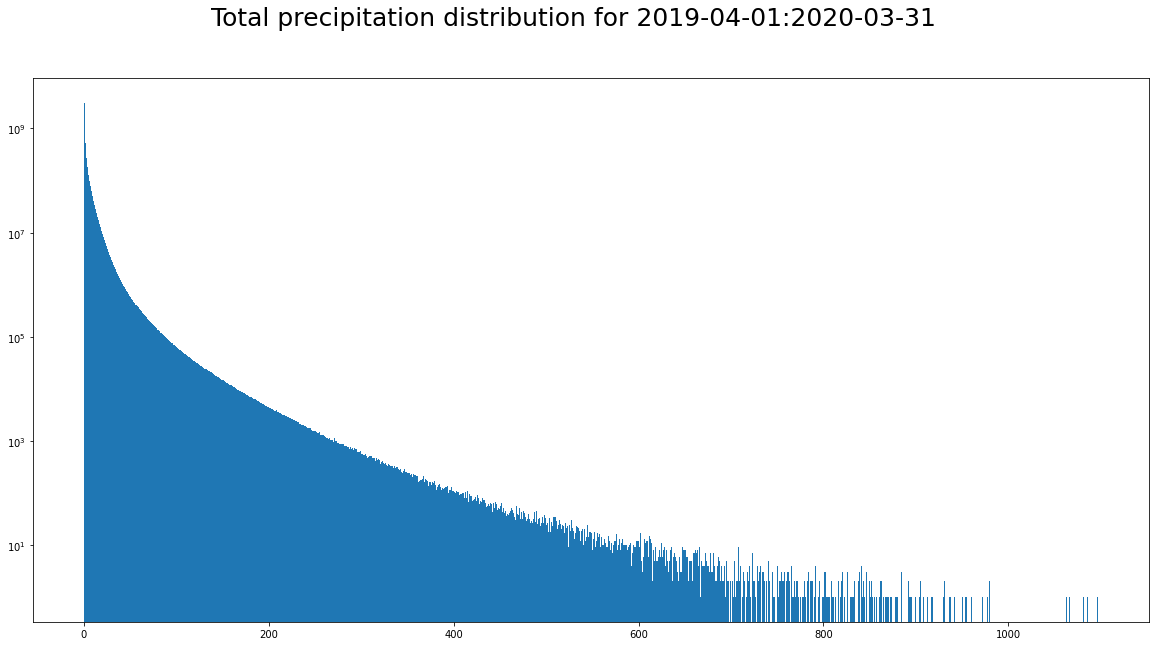

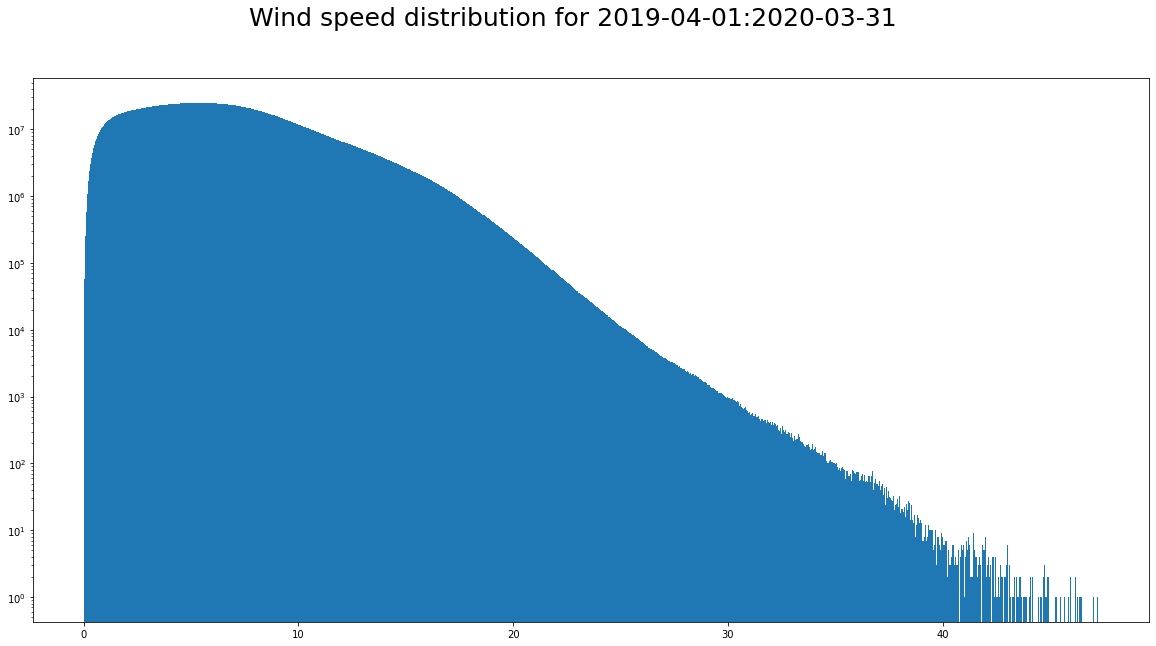

In [16]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} distribution for 2019-04-01:2020-03-31', fontsize=25)
    plt.hist(proc[list(proc.data_vars)[i]].values.flatten(), bins=1000, cumulative=False, log=True);
    plt.show()

#### After masking and rounding of values (0, 1) to 0:

In [17]:
mask = ~np.isnan(xr.open_dataset('/nvme0/fwi-forecast/ECMWF_FWI_20190130_1200_hr_fwi.nc')['fwi'][0].values)

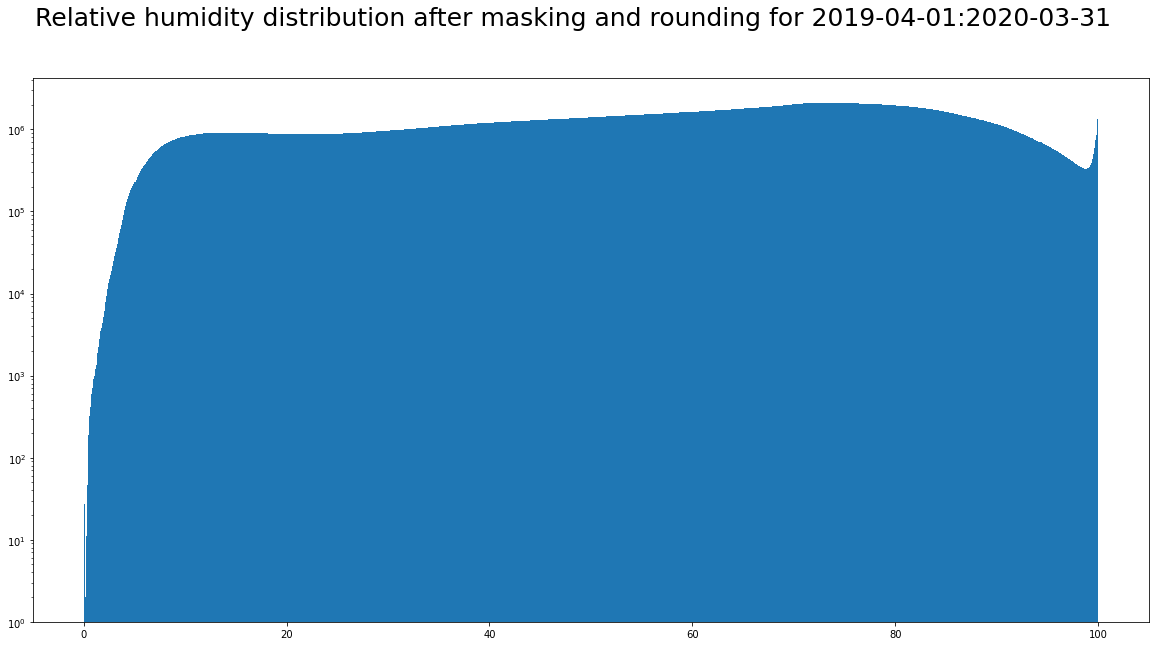

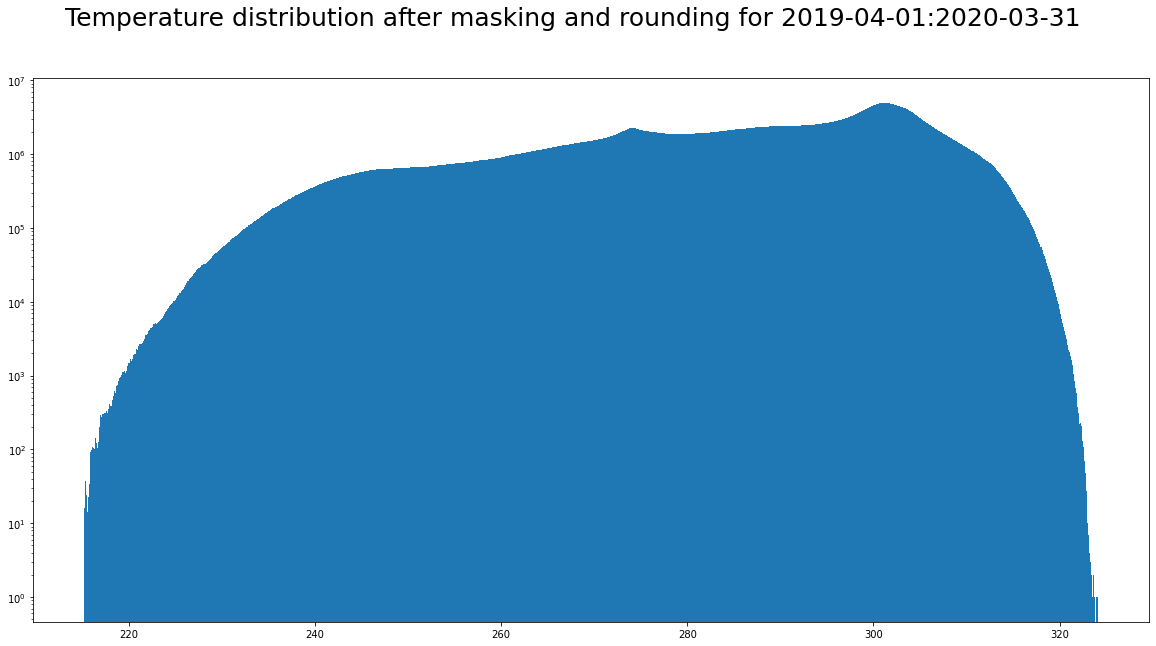

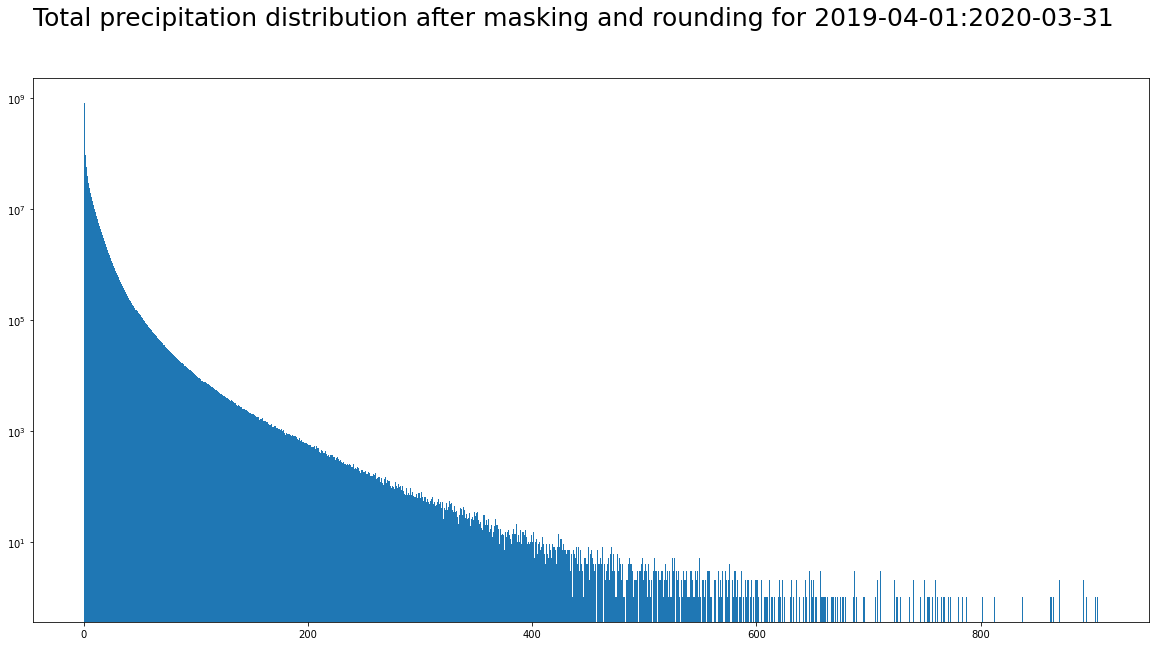

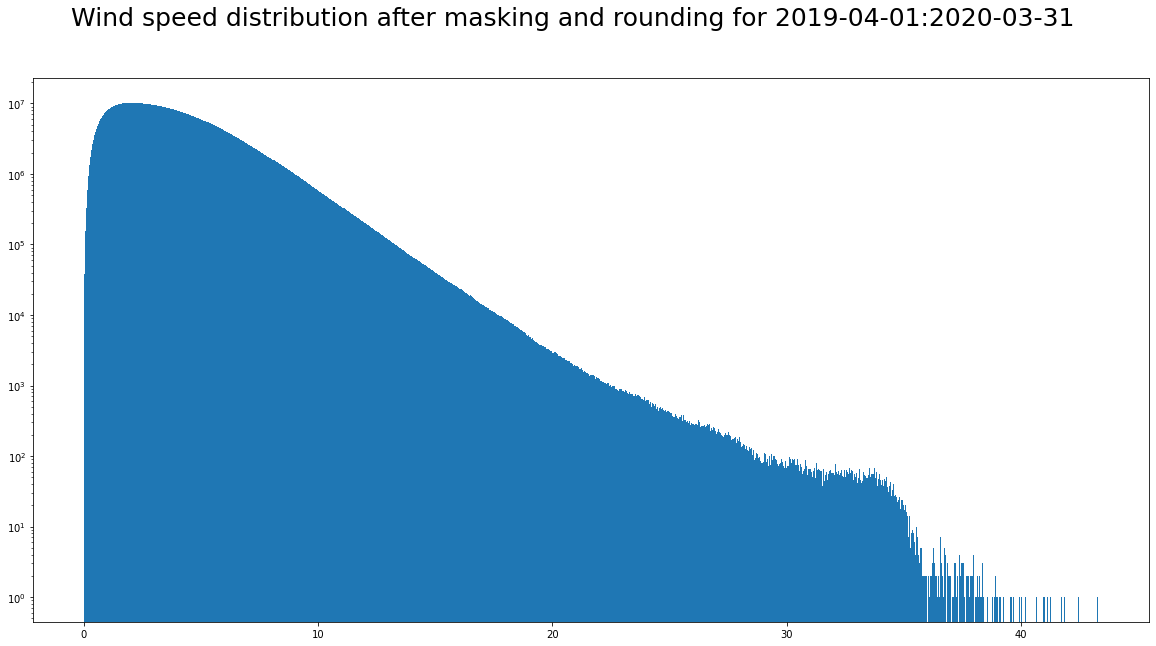

In [22]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
var_values = [proc[list(proc.data_vars)[i]].values[np.broadcast_to(mask, (366,)+mask.shape)] for i in range(4)]
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'{var_list[i]} distribution after masking and rounding for 2019-04-01:2020-03-31', fontsize=25)
    plt.hist(var_values[i].flatten(), bins=1000, cumulative=False, log=True);
    plt.show()

In [36]:
for i in range(4):
    print(f"\n{var_list[i]} stats:")
    stats(var_values[i])


Relative humidity stats:
mean 56.859417
mad 20.268408
var 575.197
min 0.0013500393
max 100.02721

Temperature stats:
mean 285.44803
mad 15.30315
var 341.33627
min 215.15492
max 324.16202

Total precipitation stats:
mean 2.2640793
mad 3.053967
var 37.11883
min 0.0
max 905.0041

Wind speed stats:
mean 3.7924356
mad 1.8762383
var 5.8392515
min 6.484985e-05
max 43.29857



#### Box-Cox transformation

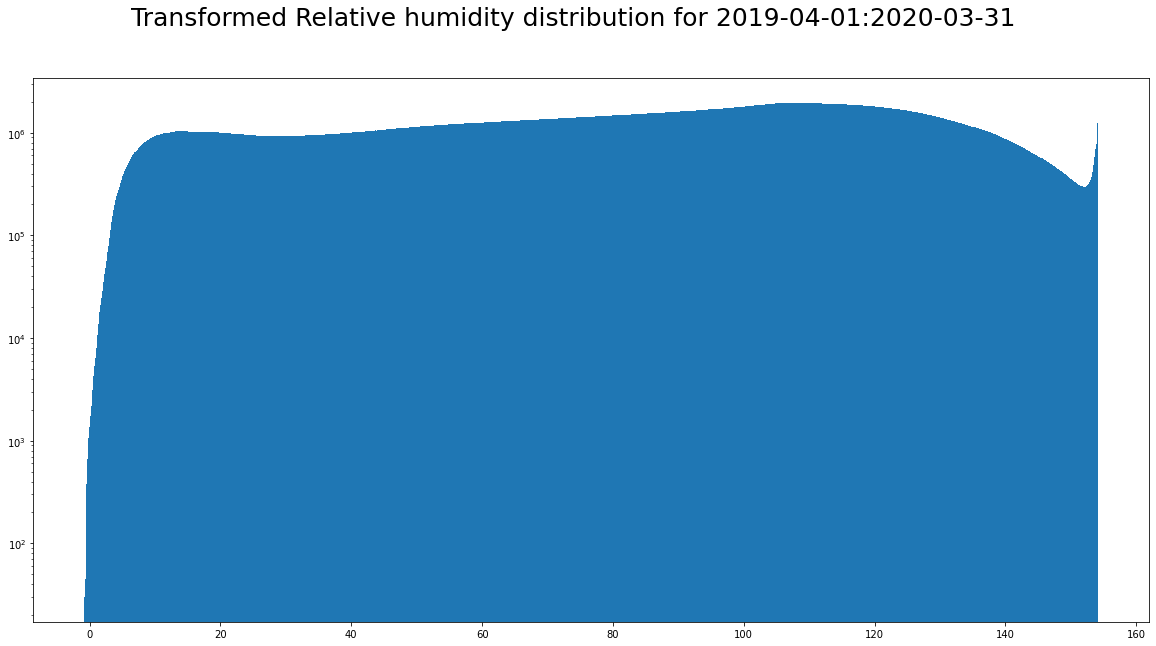

/home/esowc/anaconda3/envs/wildfire-dl/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [ ]:
var_list =['Relative humidity', 'Temperature', 'Total precipitation', 'Wind speed']
transformed = []
for i in range(4):
    plt.figure(figsize = (20,10)).suptitle(f'Transformed {var_list[i]} distribution for 2019-04-01:2020-03-31', fontsize=25)
    transformed.append(boxcox(var_values[i]))
    plt.hist(transformed[-1][0].flatten(), bins=1000, cumulative=False, log=True);
    plt.show()

In [ ]:
for i in range(4):
    print(f"\n{var_list[i]} lambda:")
    print(transformed[i][1])

In [ ]:
for i in range(4):
    print(f"\n{var_list[i]} stats:")
    stats(transformed[i][0])